## For Part A 

The values in the given data that are corrupted are not being used by us in order to calculate the number of cars entering the parking lot per day. We have simply calculated the number of entries in the data which correspond to camera_id = 1 for each day. This gives us number of cars entering the mall with 100\% accuracy. 
<br>
Since we have bypassed corrputed data, we don't need to clean it any more. Therefore, no data cleaning is needed part 1.

## For Part B

For this part, we are calculating the average time spent by a car at the mall at a given day as:  $$Average Time Spent By A Car on a given Day = \frac{Sum Of Timestamps of Cars Leaving - Sum Of Timestamps Of Cars Entering}{Number Of Cars That Visited Parking Lot}$$ 
Again, in this part as well, we are not using the component of the data that is corrupted, since for calculating the timestamps of cars entering or leaving, we do not really need the vehicle number plates. So we don't care about the number plate of vehicle not being there or being read incorrectly, only thing we care about is that for each car entering and exiting the parking lot, we have the corresponding entry in our data, which is true for the given data (as analysed in Q1b.ipynb). Therefore we do not need any sort of data imputation technique in this. 

# Data Imputation and Outlier Analysis in Part A

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.arima import AutoARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima.model import ARIMA
import warnings

In [20]:
warnings.filterwarnings("ignore")
parking_data = pd.read_csv('parkingLot (1).csv')
car_entering_data = parking_data[(parking_data['camera_id']==1)]
car_entering_data['timestamp'] = pd.to_datetime(car_entering_data['timestamp'])
car_entering_data['Count'] = 1
cars_per_day = car_entering_data.groupby(pd.Grouper(key='timestamp', freq='D'))['Count'].sum()

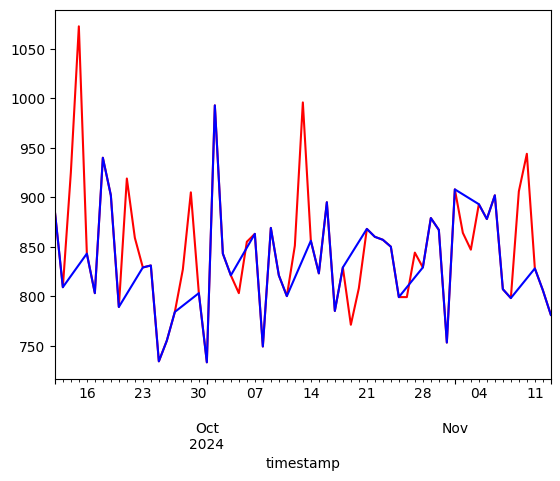

In [21]:
weekdays = cars_per_day[cars_per_day.index.weekday < 5]
cars_per_day.plot(color='red')
weekdays.plot(color='blue')
plt.show()

In [22]:
weekdays

timestamp
2024-09-12    886
2024-09-13    809
2024-09-16    843
2024-09-17    803
2024-09-18    940
2024-09-19    902
2024-09-20    789
2024-09-23    829
2024-09-24    831
2024-09-25    734
2024-09-26    755
2024-09-27    784
2024-09-30    803
2024-10-01    733
2024-10-02    993
2024-10-03    843
2024-10-04    821
2024-10-07    863
2024-10-08    749
2024-10-09    869
2024-10-10    821
2024-10-11    800
2024-10-14    856
2024-10-15    823
2024-10-16    895
2024-10-17    785
2024-10-18    829
2024-10-21    868
2024-10-22    860
2024-10-23    857
2024-10-24    850
2024-10-25    799
2024-10-28    829
2024-10-29    879
2024-10-30    867
2024-10-31    753
2024-11-01    908
2024-11-04    893
2024-11-05    878
2024-11-06    902
2024-11-07    807
2024-11-08    798
2024-11-11    828
2024-11-12    806
2024-11-13    781
Name: Count, dtype: int64

In [23]:
def ema(series, lag):
	return series.ewm(span=lag).mean()

Let us try to analyse the trend of the spikes in the data.

In [24]:
# trying to find the trend of spikes in data
mean_series = cars_per_day.rolling(window=5).mean()
mean_series[:5] = mean_series[5]

In [25]:
mask_upper_outlier = cars_per_day > mean_series * 1.13
mask_lower_outlier = cars_per_day < mean_series * 0.9
mask_upper_outlier.sum(), mask_lower_outlier.sum()

(3, 1)

<Axes: xlabel='timestamp'>

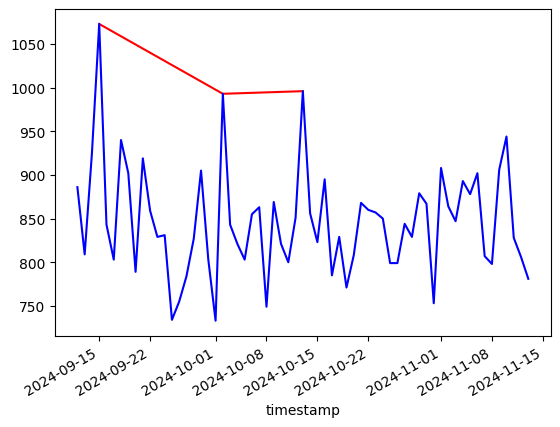

In [26]:
cars_per_day[mask_upper_outlier].plot(color='red')
cars_per_day[mask_lower_outlier].plot(color='green')
cars_per_day.plot(color='blue')

In [27]:
# Replace all the values weekdays outliers by rolling mean
cars_per_day[mask_upper_outlier] = mean_series[mask_upper_outlier]
# cars_per_day[mask_lower_outlier] = mean_series[mask_lower_outlier]


## Generate Forecasts

In [28]:
_train, _test = cars_per_day[:int(len(cars_per_day)*0.85)], cars_per_day[int(len(cars_per_day)*0.85):]

In [29]:
forecaster = AutoARIMA(seasonal=False, suppress_warnings=True)
forecaster.fit(_train)
forecaster.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:                        SARIMAX   Log Likelihood                -280.570
Date:                Sun, 27 Oct 2024   AIC                            565.141
Time:                        19:46:30   BIC                            569.081
Sample:                    09-12-2024   HQIC                           566.656
                         - 11-03-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    836.8340      6.674    125.384      0.000     823.753     849.915
sigma2      2320.8434    503.371      4.611      0.000    1334.255    3307.432
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.90   Prob(JB):                         0.76
Heteroskedasticity (H):               0.44   Skew:                            -0.17
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
forecaster.get_fitted_params()

{'intercept': 836.8339622641511,
 'sigma2': 2320.843374866501,
 'order': (0, 0, 0),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 565.1408383989981,
 'aicc': 565.3808383989981,
 'bic': 569.0814222261023,
 'hqic': 566.6561968864297}